In [1]:
import os
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from itertools import combinations, product
import random
import json
from Bio import pairwise2
from Bio.pairwise2 import format_alignment

/public/home/tanyang/miniconda3/envs/protssn/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [13]:
np.load('result/cath_v43_s20/cath_large_metadata.npy')

array(['cath|4_3_0|101mA00/0-153', 'cath|4_3_0|102lA00/1-162',
       'cath|4_3_0|102mA00/0-153', ..., 'cath|4_3_0|9ximB00/3-394',
       'cath|4_3_0|9ximC00/4-394', 'cath|4_3_0|9ximD00/3-394'],
      dtype='<U66')

In [2]:
cath_large_dict = {}
for name, embed in zip(np.load('result/cath_v43_s20/cath_large_metadata.npy'), np.load('result/cath_v43_s20/cath_large.npy')):
    name = name.split("|")[-1].split('/')[0]
    cath_large_dict[name] = torch.tensor(embed).squeeze()

In [17]:
torch.save(cath_large_dict, 'result/cath_v43_s20/tmvec_cath_large_download.pt')

In [2]:
def norm_embed_dict(embed_dict):
    names, embeds = [], []
    for k, v in embed_dict.items():
        embeds.append(v.unsqueeze(0))
        names.append(k)
    embeds = torch.cat(embeds, dim=0)
    if embeds.dtype == torch.float16:
        embeds = embeds.to(torch.bfloat16)
    embeds = F.normalize(embeds, p=2, dim=1)
    norm_embed_dict = {}
    for idx, name in enumerate(names):
        norm_embed_dict[name] = embeds[idx]
    return norm_embed_dict

cath_43_mask_embeds = norm_embed_dict(torch.load("result/cath_v43_s20/graph_foldseek_0.5m_50e.pt"))
# cath_43_embeds = norm_embed_dict(torch.load("result/20231129/cath_v43_s20_graph_foldseek/embeds.pt"))

In [6]:
torch.mm(cath_43_mask_embeds['3i84B00'].unsqueeze(0), cath_43_mask_embeds['1f0iA02'].unsqueeze(0).T)

tensor([[0.8762]])

In [36]:
def numbers_to_letters(numbers):
    # 创建数字到字母的映射
    mapping = {i: chr(65 + i) for i in range(20)}
    # 转换数字序列到字母序列
    letters = ''.join(mapping[number] for number in numbers)
    return letters

In [3]:
cath_s_seq_dict = {}
with open("result/struct_to_seq/cath_v43_s20.json", "r") as f:
    lines = f.readlines()
    for line in lines:
        line = json.loads(line)
        cath_s_seq_dict[line["name"].split('.')[0]] = numbers_to_letters(line["cath_km20_s_seq"])

NameError: name 'numbers_to_letters' is not defined

In [3]:
tm_scores = torch.load("result/cath_v43_s20/tmalign.pt")
tm_score_index = tm_scores['index']
tm_score_high_matrix = tm_scores['tm_score_high_matrix']
tm_score_mean_matrix = tm_scores['tm_score_mean_matrix']

foldseek_aln0 = torch.load("result/cath_v43_s20/foldseek_aln_0.pt")
foldseek_aln0_index = foldseek_aln0['index']
foldseek_aln0_matrix = foldseek_aln0['foldseek_prob_matrix']

foldseek_aln2 = torch.load("result/cath_v43_s20/foldseek_aln_2.pt")
foldseek_aln2_index = foldseek_aln2['index']
foldseek_aln2_matrix = foldseek_aln2['foldseek_prob_matrix']

# esmif_last_embed = norm_embed_dict(torch.load("result/cath_v43_s20/esmif_last.pt"))
esmif_mean_embed = norm_embed_dict(torch.load("result/cath_v43_s20/esmif_mean.pt"))
mifst_embed = norm_embed_dict(torch.load("result/cath_v43_s20/mifst.pt"))
prostt5_embed = norm_embed_dict(torch.load("result/cath_v43_s20/prostt5.pt"))
prostt5_aa2fold_embed = norm_embed_dict(torch.load("result/cath_v43_s20/prostt5_aa2fold.pt"))
tmvec_embed = norm_embed_dict(torch.load("result/cath_v43_s20/tm_vec_swiss_model.pt"))
# tmvec_embed = torch.load("result/cath_v43_s20/tmvec_cath_large.pt")
esm2_embed = norm_embed_dict(torch.load("result/cath_v43_s20/esm2_t33_650M_UR50D.pt"))
esm2_3B_emebd = norm_embed_dict(torch.load("result/cath_v43_s20/esm2_t36_3B_UR50D.pt"))
esm2_15B_emebd = norm_embed_dict(torch.load("result/cath_v43_s20/esm2_t48_15B_UR50D.pt"))

def predict_mask_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(cath_43_mask_embeds[pdb1].unsqueeze(0), cath_43_mask_embeds[pdb2].unsqueeze(1)))
    return sim_score

def s_seq_domain_sim(pdb1, pdb2):
    global_alignments = pairwise2.align.globalxx(cath_s_seq_dict[pdb1], cath_s_seq_dict[pdb2])
    sim_score = global_alignments[0].score / len(cath_s_seq_dict[pdb1]) + global_alignments[0].score / len(cath_s_seq_dict[pdb2])
    return sim_score / 2

def esmif_last_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(esmif_last_embed[pdb1].unsqueeze(0), esmif_last_embed[pdb2].unsqueeze(1)))
    return sim_score

def mifst_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(mifst_embed[pdb1].unsqueeze(0), mifst_embed[pdb2].unsqueeze(1)))
    return sim_score

def esmif_mean_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(esmif_mean_embed[pdb1].unsqueeze(0), esmif_mean_embed[pdb2].unsqueeze(1)))
    return sim_score

def tm_high_domain_sim(pdb1, pdb2):
    sim_score = float(tm_score_high_matrix[tm_score_index[pdb1], tm_score_index[pdb2]])
    return sim_score

def tm_mean_domain_sim(pdb1, pdb2):
    sim_score = float(tm_score_mean_matrix[tm_score_index[pdb1], tm_score_index[pdb2]])
    return sim_score

def foldseek_aln0_domain_sim(pdb1, pdb2):
    sim_score = float(foldseek_aln0_matrix[foldseek_aln0_index[pdb1], foldseek_aln0_index[pdb2]])
    return sim_score

def foldseek_aln2_domain_sim(pdb1, pdb2):
    sim_score = float(foldseek_aln2_matrix[foldseek_aln2_index[pdb1], foldseek_aln2_index[pdb2]])
    return sim_score

def prostt5_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(torch.tensor(prostt5_embed[pdb1].unsqueeze(0), dtype=torch.bfloat16), torch.tensor(prostt5_embed[pdb2].unsqueeze(1), dtype=torch.bfloat16)))
    return sim_score

def prostt5_aa2fold_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(torch.tensor(prostt5_aa2fold_embed[pdb1].unsqueeze(0), dtype=torch.bfloat16), torch.tensor(prostt5_aa2fold_embed[pdb2].unsqueeze(1), dtype=torch.bfloat16)))
    return sim_score

def tmvec_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(tmvec_embed[pdb1].unsqueeze(0), tmvec_embed[pdb2].unsqueeze(1)))
    return sim_score

def esm2_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(esm2_embed[pdb1].unsqueeze(0), esm2_embed[pdb2].unsqueeze(1)))
    return sim_score

def esm2_3B_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(esm2_3B_emebd[pdb1].unsqueeze(0), esm2_3B_emebd[pdb2].unsqueeze(1)))
    return sim_score

def esm2_15B_domain_sim(pdb1, pdb2):
    sim_score = float(torch.mm(esm2_15B_emebd[pdb1].unsqueeze(0), esm2_15B_emebd[pdb2].unsqueeze(1)))
    return sim_score

def plot_auc(selected_samples, category1, category2):
    pos_samples = selected_samples[category1]
    neg_samples = selected_samples[category2]   

    print(len(pos_samples), len(neg_samples))
    samples = pos_samples + neg_samples
    y_true = [1]* len(pos_samples) + [0]*len(neg_samples)
    # y_pred = []
    y_seq_pred = []
    y_mask_pred = []
    y_tm_high_pred = []
    y_tm_mean_pred = []
    # y_esmif_last_pred = []
    y_esmif_mean_pred = []
    y_mifst_pred = []
    y_prostt5_pred = []
    y_prostt5_aa2fold_pred = []
    y_tmvec_pred = []
    y_esm2_pred = []
    y_esm2_3B_pred = []
    y_esm2_15B_pred = []
    y_foldseek_aln0_pred = []
    y_foldseek_aln2_pred = []
    
    for sample in tqdm(samples):
        pdb1, pdb2, match_level = sample
        # y_pred.append(predict_domain_sim(pdb1, pdb2))
        # y_seq_pred.append(s_seq_domain_sim(pdb1, pdb2))
        y_mask_pred.append(predict_mask_domain_sim(pdb1, pdb2))
        y_tm_high_pred.append(tm_high_domain_sim(pdb1, pdb2))
        y_tm_mean_pred.append(tm_mean_domain_sim(pdb1, pdb2))
        # y_esmif_last_pred.append(esmif_last_domain_sim(pdb1, pdb2))
        y_esmif_mean_pred.append(esmif_mean_domain_sim(pdb1, pdb2))
        y_mifst_pred.append(mifst_domain_sim(pdb1, pdb2))
        y_prostt5_pred.append(prostt5_domain_sim(pdb1, pdb2))
        y_prostt5_aa2fold_pred.append(prostt5_aa2fold_domain_sim(pdb1, pdb2))
        y_tmvec_pred.append(tmvec_domain_sim(pdb1, pdb2))
        y_esm2_pred.append(esm2_domain_sim(pdb1, pdb2))
        y_esm2_3B_pred.append(esm2_3B_domain_sim(pdb1, pdb2))
        y_esm2_15B_pred.append(esm2_15B_domain_sim(pdb1, pdb2))
        y_foldseek_aln0_pred.append(foldseek_aln0_domain_sim(pdb1, pdb2))
        y_foldseek_aln2_pred.append(foldseek_aln2_domain_sim(pdb1, pdb2))

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    # roc_auc = auc(fpr, tpr)
    
    # frp_s_seq, tpr_s_seq, thresholds_s_seq = roc_curve(y_true, y_seq_pred)
    # roc_auc_s_seq = auc(frp_s_seq, tpr_s_seq)
    
    fpr_mask, tpr_mask, thresholds_mask = roc_curve(y_true, y_mask_pred)
    roc_auc_mask = auc(fpr_mask, tpr_mask)

    fpr_tm_high, tpr_tm_high, thresholds_tm_high = roc_curve(y_true, y_tm_high_pred)
    roc_auc_tm_high = auc(fpr_tm_high, tpr_tm_high)
    
    fpr_tm_mean, tpr_tm_mean, thresholds_tm_mean = roc_curve(y_true, y_tm_mean_pred)
    roc_auc_tm_mean = auc(fpr_tm_mean, tpr_tm_mean)
    
    # fpr_esmif_last, tpr_esmif_last, thresholds_esmif_last = roc_curve(y_true, y_esmif_last_pred)
    # roc_auc_esmif_last = auc(fpr_esmif_last, tpr_esmif_last)

    fpr_esmif_mean, tpr_esmif_mean, thresholds_esmif_mean = roc_curve(y_true, y_esmif_mean_pred)
    roc_auc_esmif_mean = auc(fpr_esmif_mean, tpr_esmif_mean)
    
    fpr_mifst, tpr_mifst, thresholds_mifst = roc_curve(y_true, y_mifst_pred)
    roc_auc_mifst = auc(fpr_mifst, tpr_mifst)
    
    frp_prostt5, tpr_prostt5, thresholds_prostt5 = roc_curve(y_true, y_prostt5_pred)
    roc_auc_prostt5 = auc(frp_prostt5, tpr_prostt5)
    
    frp_prostt5_aa2fold, tpr_prostt5_aa2fold, thresholds_prostt5_aa2fold = roc_curve(y_true, y_prostt5_aa2fold_pred)
    roc_auc_prostt5_aa2fold = auc(frp_prostt5_aa2fold, tpr_prostt5_aa2fold)
    
    frp_tmvec, tpr_tmvec, thresholds_tmvec = roc_curve(y_true, y_tmvec_pred)
    roc_auc_tmvec = auc(frp_tmvec, tpr_tmvec)
    
    frp_foldseek_aln0, tpr_foldseek_aln0, thresholds_foldseek_aln0 = roc_curve(y_true, y_foldseek_aln0_pred)
    roc_auc_foldseek_aln0 = auc(frp_foldseek_aln0, tpr_foldseek_aln0)
    
    frp_foldseek_aln2, tpr_foldseek_aln2, thresholds_foldseek_aln2 = roc_curve(y_true, y_foldseek_aln2_pred)
    roc_auc_foldseek_aln2 = auc(frp_foldseek_aln2, tpr_foldseek_aln2)
    
    frp_esm2, tpr_esm2, thresholds_esm2 = roc_curve(y_true, y_esm2_pred)
    roc_auc_esm2 = auc(frp_esm2, tpr_esm2)
    
    frp_esm2_3B, tpr_esm2_3B, thresholds_esm2_3B = roc_curve(y_true, y_esm2_3B_pred)
    roc_auc_esm2_3B = auc(frp_esm2_3B, tpr_esm2_3B)
    
    frp_esm2_15B, tpr_esm2_15B, thresholds_esm2_15B = roc_curve(y_true, y_esm2_15B_pred)
    roc_auc_esm2_15B = auc(frp_esm2_15B, tpr_esm2_15B)
    
    plt.figure(figsize=(9, 5))
    # plt.plot(fpr, tpr, color='darkorange', linestyle=':', lw=2, label='Ours ROC curve (area = %0.3f)' % roc_auc)
    # plt.plot(frp_s_seq, tpr_s_seq, color='gray', linestyle=':', lw=2, label='S-Seq ROC curve (area = %0.3f)' % roc_auc_s_seq)
    plt.plot(fpr_mask, tpr_mask, color='darkorange', label='Ours ROC %0.3f' % roc_auc_mask)
    # plt.plot(fpr_esmif_last, tpr_esmif_last, color='blue', label='ESM-IF-Last ROC %0.3f' % roc_auc_esmif_last)
    plt.plot(fpr_esmif_mean, tpr_esmif_mean, color='yellow', label='ESM-IF-Mean ROC %0.3f' % roc_auc_esmif_mean)
    plt.plot(fpr_mifst, tpr_mifst, color='red', label='Mifst ROC %0.3f' % roc_auc_mifst)
    plt.plot(frp_prostt5, tpr_prostt5, color='black', label='ProstT5 ROC %0.3f' % roc_auc_prostt5)
    plt.plot(frp_prostt5_aa2fold, tpr_prostt5_aa2fold, color='green', label='ProstT5-AA2Fold ROC %0.3f' % roc_auc_prostt5_aa2fold)
    
    plt.plot(frp_esm2, tpr_esm2, color='magenta', label='ESM2 ROC %0.3f' % roc_auc_esm2)
    plt.plot(frp_esm2_3B, tpr_esm2_3B, color='cyan', label='ESM2-3B ROC %0.3f' % roc_auc_esm2_3B)
    plt.plot(frp_esm2_15B, tpr_esm2_15B, color='purple', label='ESM2-15B ROC %0.3f' % roc_auc_esm2_15B)
    plt.plot(frp_tmvec, tpr_tmvec, color='blue', label='TM-Vec ROC %0.3f' % roc_auc_tmvec)
    
    plt.plot(fpr_tm_high, tpr_tm_high, color='green',linestyle=':', label='TM-High ROC %0.3f' % roc_auc_tm_high)
    plt.plot(fpr_tm_mean, tpr_tm_mean, color='red', linestyle=':', label='TM-Mean ROC %0.3f' % roc_auc_tm_mean)
    plt.plot(frp_foldseek_aln0, tpr_foldseek_aln0, color='purple', linestyle=':', label='FoldSeek-3Di ROC %0.3f' % roc_auc_foldseek_aln0)
    plt.plot(frp_foldseek_aln2, tpr_foldseek_aln2, color='cyan', linestyle=':', label='FoldSeek-3Di-AA ROC %0.3f' % roc_auc_foldseek_aln2)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{category1} vs {category2}')
    
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()  # 调整布局以适应图例
    plt.show()

10000 10000


  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_102333/716207245.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_score = float(torch.mm(torch.tensor(prostt5_embed[pdb1].unsqueeze(0), dtype=torch.bfloat16), torch.tensor(prostt5_embed[pdb2].unsqueeze(1), dtype=torch.bfloat16)))
/tmp/ipykernel_102333/716207245.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sim_score = float(torch.mm(torch.tensor(prostt5_aa2fold_embed[pdb1].unsqueeze(0), dtype=torch.bfloat16), torch.tensor(prostt5_aa2fold_embed[pdb2].unsqueeze(1), dtype=torch.bfloat16)))
  4%|▎         | 728/20000 [00:00<00:05, 3665.92it/s]

100%|██████████| 20000/20000 [00:10<00:00, 1851.17it/s]


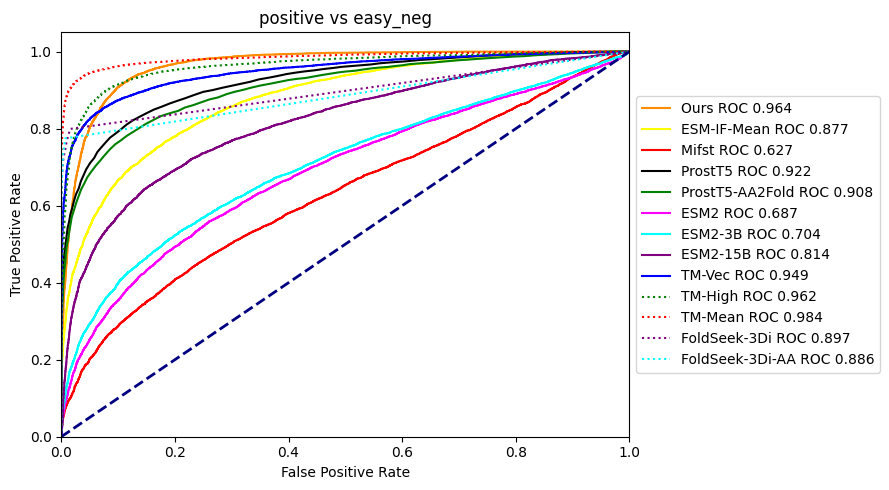

In [7]:
selected_samples = json.load(open("benchmark/cath_v43_s20/domain_pair_dict_3.json", "r"))
plot_auc(selected_samples, 'positive', 'easy_neg')

In [27]:
len(json.load(open("benchmark/cath_v43_s20/cath_domain_dict.json", "r")).keys())

855

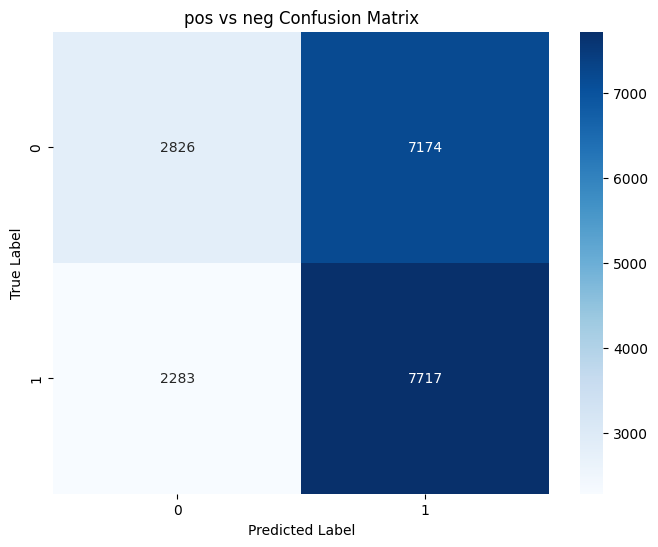

In [61]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 确定阈值
threshold = 0.97

# 将连续的分数转换为二元类别
y_pred_binary = [1 if score >= threshold else 0 for score in y_pred]

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred_binary)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('pos vs neg Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

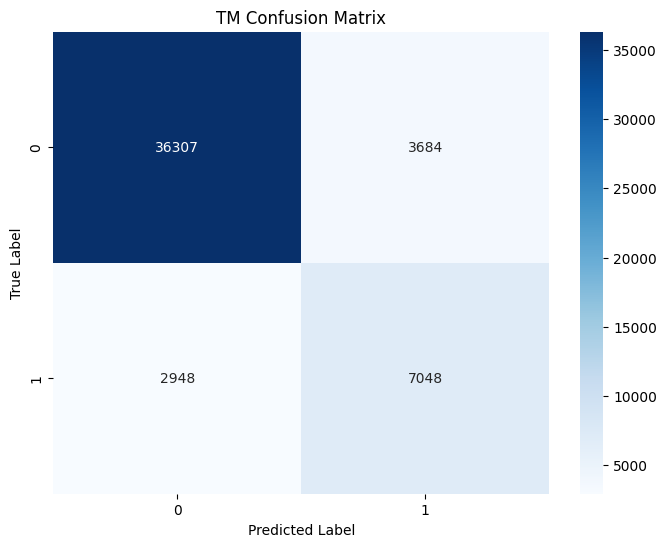

In [150]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 确定阈值
threshold = 0.5

# 将连续的分数转换为二元类别
y_pred_binary = [1 if score >= threshold else 0 for score in y_tm_pred]

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred_binary)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('TM Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [69]:
acc = 0
for sample in selected_samples['easy_neg']:
    pdb1, pdb2, match_level = sample
    predict_level = predict_domain_sim(pdb1, pdb2)
    if predict_level == match_level:
        acc += 1
acc / len(embed_sim_dict['easy_neg'])

0.8773

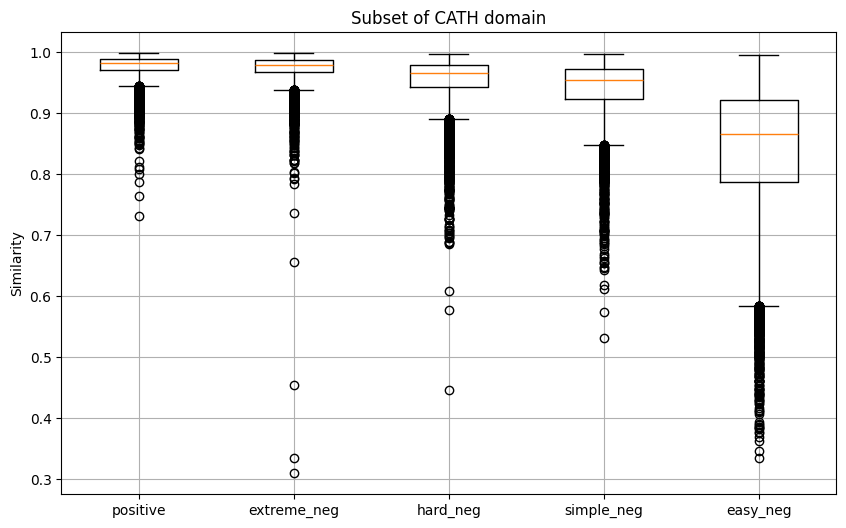

In [8]:
import matplotlib.pyplot as plt

def plot_boxplot(data_dict):
    """
    Plots a boxplot for the given dictionary. 
    The keys of the dictionary are categories and the values are lists of numbers.
    
    :param data_dict: A dictionary where keys are categories and values are lists of numbers.
    """
    # Preparing data for plotting
    labels, data = zip(*data_dict.items())

    # Creating the boxplot
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=labels)
    plt.title("Subset of CATH domain")
    plt.ylabel("Similarity")
    plt.grid(True)
    plt.show()

# Example usage
example_data = {
    "Category 1": [1, 2, 3, 4, 5, 6],
    "Category 2": [2, 3, 4, 5, 6, 7],
    "Category 3": [3, 4, 5, 6, 7, 8]
}

plot_boxplot(embed_sim_dict)  # This line plots the boxplot for the example data